In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import mutual_info_regression as MIR

In [2]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [3]:
format_plots()

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()

In [6]:
## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)


female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]


# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [7]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))

m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

/tmp/ipykernel_1879/1663783390.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_data['sex'] = 'm'
/tmp/ipykernel_1879/1663783390.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['sex'] = 'f'


In [8]:
#average and normalize male
avg_m_df = m_data.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_data)
avg_m_norm = mm_norm_col(avg_m_df)

#average and normalize female
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)
data=pd.concat([m_data,f_data])

In [9]:
## MI for age in ontogeny

In [10]:
X = m_data.to_numpy()
y = list(m_data.index.get_level_values('age'))
mi_score_m = MIR(X,y)
mi_shf=[]

it=100
for i in tqdm(range(it)):
    ytemp = random.shuffle(y)
    mi_temp = MIR(X,y)
    mi_shf.extend(mi_temp)

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
m_sh_m=np.percentile(mi_shf, 95, axis=0)

In [12]:
# Create figure and axis
df = pd.DataFrame()
df['mi'] = np.concatenate((np.array(mi_score_m),
                      np.array(mi_shf)))

df['exp'] = np.concatenate((len(np.array(mi_score_m)) * ['m'],
                         len(np.array(mi_shf)) * ['shf']))
df_m=df.copy()

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


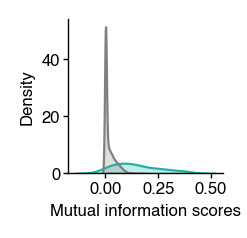

In [13]:
# Create figure and axis
fig = plt.figure(figsize=(1, 1))
ax = fig.gca()
sns.kdeplot(mi_score_m,fill=True,color = '#20B2AA',ax=ax)
sns.kdeplot(mi_shf, fill=True,color = 'gray',ax=ax)

#sns.displot(mi_score_m, kind="kde",fill=True,color = '#20B2AA',ax=ax)
#sns.displot(mi_shf, kind="kde",fill=True,color = 'gray',ax=ax)

plt.xlabel('Mutual information scores')
sns.despine()

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'MI_age_male.pdf', bbox_inches='tight')

In [15]:
X = f_data.to_numpy()
y = list(f_data.index.get_level_values('age'))
mi_score_f = MIR(X,y)
mi_shf_f=[]

it=100
for i in tqdm(range(it)):
    ytemp = random.shuffle(y)
    mi_temp = MIR(X,y)
    mi_shf_f.extend(mi_temp)

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
m_sh_f=np.percentile(mi_shf_f, 95, axis=0)

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


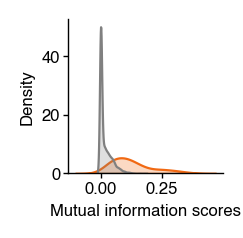

In [17]:
# Create figure and axis
fig = plt.figure(figsize=(1, 1))
ax = fig.gca()
sns.kdeplot(mi_score_f,fill=True,color = '#f16913',ax=ax)
sns.kdeplot(mi_shf_f, fill=True,color = 'gray',ax=ax)

#sns.displot(mi_score_m, kind="kde",fill=True,color = '#20B2AA',ax=ax)
#sns.displot(mi_shf, kind="kde",fill=True,color = 'gray',ax=ax)

plt.xlabel('Mutual information scores')
sns.despine()

In [18]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'MI_age_female.pdf', bbox_inches='tight')

In [19]:
## directly compare male/female

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


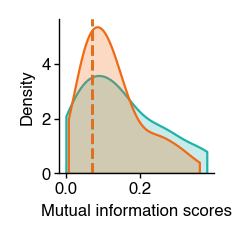

In [20]:
# Create figure and axis
fig = plt.figure(figsize=(1, 1))
ax = fig.gca()
sns.kdeplot(mi_score_m,fill=True,color = '#20B2AA',ax=ax, cut=0)
sns.kdeplot(mi_score_f,fill=True,color = '#f16913',ax=ax, cut=0)
# Add dotted vertical lines
ax.axvline(m_sh_m, linestyle='--', color='#20B2AA')
ax.axvline(m_sh_f, linestyle='--', color='#f16913')
plt.xlabel('Mutual information scores')
sns.despine()

In [21]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'MI_age_fvm.pdf', bbox_inches='tight')

In [24]:
# stats
from scipy import stats
ks_statistic, p_value = stats.ks_2samp(mi_score_m, mi_score_f)

In [25]:
print(p_value)

0.6437606614697101


In [28]:
ks_statistic

0.13793103448275862